# Configure font

In [1]:
# Configure Arial as the default font in all figures

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm


arial_font_path = '/PATH/TO/ARIAL/FONT/arial.ttf'

fm.fontManager.addfont(arial_font_path)

plt.rcParams['font.family'] = 'Arial'

# Path to Zenodo files folder

In [1]:
path = 'PATH/TO/ZENODO/FILES/FOLDER'

# Figure S10

## Panels A&B

In [3]:
import pandas as pd
core_variants = pd.read_csv(path+'Fig5/FYN_core_randomization_fitness_replicates.txt',sep='\t', low_memory=False)

mut_pos_numbers = [2, 4, 8, 10, 15, 16, 18, 22, 24, 26, 35, 37, 48, 52, 53]

def extract_core(seq, positions):
    return ''.join(seq[pos] for pos in positions if len(seq) >= pos)

core_variants['core'] = core_variants['aa_seq'].apply(lambda seq: extract_core(seq, mut_pos_numbers))

In [4]:
import pandas as pd
from protlearn.features import aaindex1

amino_acids = list('ACDEFGHIKLMNPQRSTVWY')
aaind, inds = aaindex1(amino_acids)
DTS_AA_props = pd.DataFrame(data=aaind, columns=inds, index=amino_acids)

sidechain_atoms = pd.read_csv(path+'FigS2/amino_acid_heavy_atoms_and_carbons.csv',sep=',',index_col=0)
sidechain_atoms=sidechain_atoms.drop('Amino Acid',axis=1)
sidechain_atoms=sidechain_atoms.rename(columns={'Heavy Atoms':'SCHeavyAtoms','Carbons in Sidechain':'SCCarbons'})

DTS_AA_props = pd.concat([DTS_AA_props,sidechain_atoms],axis=1)

aa_props_dict = DTS_AA_props.to_dict(orient="index")

def compute_sequence_props(sequence, aa_props_dict):
    property_sums = {prop: 0 for prop in DTS_AA_props.columns}
    for aa in sequence:
        if aa in aa_props_dict:
            for prop, value in aa_props_dict[aa].items():
                property_sums[prop] += value
    return property_sums

result_data = []
for sequence in core_variants["core"]:
    sequence_props = compute_sequence_props(sequence, aa_props_dict)
    result_data.append(sequence_props)

AA_properties_sum = pd.DataFrame(result_data, columns=DTS_AA_props.columns)
AA_properties_sum.index = core_variants.index


/users/project/prj004631/aescobedo/miniconda3/envs/BIO/lib/python3.12/site-packages/protlearn/features/aaindex1.py:8: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [5]:
fyn_wt = 'TLFVALYDYEARTEDDLSFHKGEKFQILNSSEGDWWEARSLTTGETGYIPSNYVAPV'
wt_cores = {'P06241':''.join(fyn_wt[pos] for pos in mut_pos_numbers if len(fyn_wt) >= pos)}

wt_properties_sum = {}
for protein, wt_sequence in wt_cores.items():
    wt_properties_sum[protein] = compute_sequence_props(wt_sequence, aa_props_dict)

percent_change_data = []
for idx, row in core_variants.iterrows():
    protein_name='P06241'
    sequence_props = compute_sequence_props(row["core"], aa_props_dict)
    wt_props = wt_properties_sum[protein_name]

    percent_change = {
        prop: ((sequence_props[prop] - wt_props[prop]))
        for prop in DTS_AA_props.columns
    }
    percent_change_data.append(percent_change)

percent_change_df = pd.DataFrame(percent_change_data, columns=DTS_AA_props.columns)
percent_change_df.index = core_variants.index

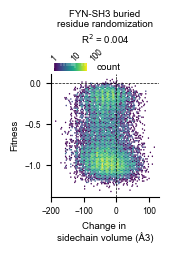

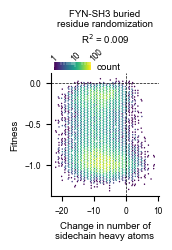

In [6]:
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr
import matplotlib.patches as mpatches
from matplotlib.ticker import MultipleLocator, AutoLocator

proteins = ['P06241']
subcategories = {'Volume':'Volume',
                'Number of sidechain heavy atoms':'#SC atoms'}
protein_names = {'P06241': 'FYN-SH3'}

for protein in proteins:
    bestindices = {'Volume': 'BIGC670101', 'Number of sidechain heavy atoms': 'SCHeavyAtoms'}
    for prop in ['Volume','Number of sidechain heavy atoms']:
        x = percent_change_df[[bestindices[prop]]].to_numpy()
        y = core_variants[['fitness']].to_numpy()
        model = LinearRegression()
        model.fit(x,y)
        y_pred = model.predict(x)
        
        fig, ax = plt.subplots(figsize=(1.4,1.6))
        hbin=ax.hexbin(y= core_variants[['fitness']],x=percent_change_df[[bestindices[prop]]],bins='log',gridsize=75,rasterized=True,linewidths=0)

        plt.axvline(0, ls='--', color='black', lw=0.5)
        plt.axhline(0, ls='--', color='black', lw=0.5)
        
        plt.title(protein_names[protein]+' buried\nresidue randomization'+'\nR$^2$ = '+str(round(r2_score(y,y_pred),3)),fontsize=7, color='k', loc='center', pad=22)
        
        plt.ylabel('Fitness', fontsize=7)
        plt.xticks(fontsize=6)
        if prop == 'Volume':
            plt.xlabel('Change in \nsidechain volume (Å3)', fontsize=7)
            merge=percent_change_df[['BIGC670101']].merge(core_variants[['fitness']],left_index=True,right_index=True)
        else:
            plt.xlabel('Change in number of\nsidechain heavy atoms',fontsize=7)
        plt.yticks(fontsize=6)
        ax = plt.gca()

        auto_locator = AutoLocator()
        default_ticks = auto_locator.tick_values(*ax.get_xlim())

        if len(default_ticks) > 1:
            tick_interval = default_ticks[1] - default_ticks[0]
            refined_locator = MultipleLocator(tick_interval*2)
            ax.xaxis.set_major_locator(refined_locator)
        ax.spines[['top','right']].set_visible(False)
        ax.set_rasterization_zorder(0)
        fmt = '%1.f'
        cax=fig.add_axes([0.15,0.9,0.3,0.05])
        cb=fig.colorbar(hbin, ax=ax, shrink=0.7,format=fmt,location='top',cax=cax)
        cb.outline.set_visible(False)
        cb.ax.tick_params(axis='both', which='both',direction='in', color='white',width=0.25)
        cb.ax.xaxis.set_tick_params(pad=0)
        cb.set_ticks([1,10,100])
        cb.set_ticklabels([1,10,100], fontsize=6, rotation=45)
        ax1 = cb.ax
        ax1.text(100,0.1,'count',rotation=0, fontsize=7)
        
        plt.show()

## Panel C

In [7]:
import pandas as pd
AAont = pd.read_csv(path+'FigS2/AAontology_SupplTable3.txt', sep='\t', encoding = "ISO-8859-1", index_col=0).drop('Unnamed: 5', axis=1)

aaindex_featureNames = pd.read_csv(path+'FigS2/AAindex_featureNames.txt',sep='\t', header=None)

aaindex_featureNames = aaindex_featureNames[0].str.split(' ', n=1, expand = True)
aaindex_id = aaindex_featureNames[0]
aaindex_featureNames = pd.concat([aaindex_id, aaindex_featureNames[1].str.split('(', n=1, expand=True)], axis=1)
aaindex_featureNames.columns = ['id', 'name', 'source']
aaindex_featureNames['name'] = aaindex_featureNames['name'].str.removesuffix(' ')
aaindex_featureNames['source'] = aaindex_featureNames['source'].str.removesuffix(')')
aaindex_featureNames = aaindex_featureNames.set_index('id')
aaindex_featureNames.at['SCHeavyAtoms','name']='Number of sidechain heavy atoms'
aaindex_featureNames.at['SCHeavyAtoms','source']='Escobedo, 2025'
aaindex_featureNames.at['SCCarbons','name']='Number of sidechain carbon atoms'
aaindex_featureNames.at['SCCarbons','source']='Escobedo, 2025'

AAont.at['SCHeavyAtoms','category']='#SC atoms'
AAont.at['SCHeavyAtoms','subcategory']='#SC atoms'
AAont.at['SCHeavyAtoms','scale_name']='Number of sidechain heavy atoms'
AAont.at['SCHeavyAtoms','scale_description']='Number of sidechain heavy atoms'

AAont.at['SCCarbons','category']='#SC atoms'
AAont.at['SCCarbons','subcategory']='#SC atoms'
AAont.at['SCCarbons','scale_name']='Number of sidechain carbon atoms'
AAont.at['SCCarbons','scale_description']='Number of sidechain carbon atoms'

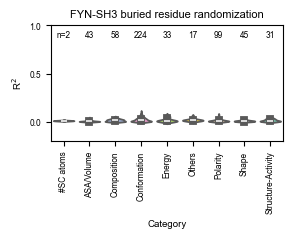

In [8]:
from scipy.stats import pearsonr
import seaborn as sns
plt.rcParams['font.family'] = 'Arial'

proteins = ['P06241']
proteins_dict = {'P06241':'FYN-SH3'}
for protein in proteins:
    
    r_all = []
    pvals = []
    for prop in percent_change_df.columns:
        x = percent_change_df[prop]
        y = core_variants['fitness']
    
        if np.all(x == x.iloc[0]):
            r_all.append(np.nan)
            pvals.append(np.nan)
        else:
            r, p = pearsonr(x, y)
            r_all.append(r)
            pvals.append(p)

    r_all = pd.DataFrame(r_all, index=percent_change_df.columns)
    r_all.columns = ['r']
    r_all['r_square'] = r_all['r']**2
    r_all = r_all.sort_values('r_square', ascending=False).dropna(subset=['r'], axis=0)

    r_all['name'] = aaindex_featureNames.loc[r_all.index, 'name']
    r_all['category'] = AAont.loc[r_all.index, 'category']
    r_all['subcategory'] = AAont.loc[r_all.index, 'subcategory']
    r_all = r_all.sort_values('category',ascending=True)

    plt.subplots(figsize=(3,1.5))
    sns.violinplot(x='category', y='r_square', data=r_all, palette='Set2', hue='category', legend=False)

    category_counts = r_all['category'].value_counts()

    for i, category in enumerate(r_all['category'].unique()):
        n = category_counts[category]
        if i == 0:
            plt.text(i, 0.9, f'n={n}', ha='center', va='center', fontsize=6)
        else:
            plt.text(i, 0.9, f'{n}', ha='center', va='center', fontsize=6)
    
    plt.xticks(rotation=90,fontsize=6)
    plt.yticks(fontsize=6)
    plt.xlabel('Category', fontsize=7)
    plt.ylabel('R$^2$', fontsize=7)
    plt.ylim(-0.2,1)
    plt.title(proteins_dict[protein]+' buried residue randomization',fontsize=8)
    plt.show()

## Panels D&E

In [9]:
import pandas as pd
core_variants = pd.read_csv(path+'Fig5/FYN_surface_randomization_fitness_replicates.txt',sep='\t', low_memory=False)

mut_pos_numbers = [0, 5, 6, 7, 9, 11, 12, 13, 14, 19, 20, 27, 30, 31, 32, 33, 41, 42, 51, 55, 56]

def extract_core(seq, positions):
    return ''.join(seq[pos] for pos in positions if len(seq) >= pos)

core_variants['core'] = core_variants['aa_seq'].apply(lambda seq: extract_core(seq, mut_pos_numbers))

In [10]:
import pandas as pd
from protlearn.features import aaindex1

amino_acids = list('ACDEFGHIKLMNPQRSTVWY')
aaind, inds = aaindex1(amino_acids)
DTS_AA_props = pd.DataFrame(data=aaind, columns=inds, index=amino_acids)

sidechain_atoms = pd.read_csv(path+'FigS2/amino_acid_heavy_atoms_and_carbons.csv',sep=',',index_col=0)
sidechain_atoms=sidechain_atoms.drop('Amino Acid',axis=1)
sidechain_atoms=sidechain_atoms.rename(columns={'Heavy Atoms':'SCHeavyAtoms','Carbons in Sidechain':'SCCarbons'})

DTS_AA_props = pd.concat([DTS_AA_props,sidechain_atoms],axis=1)

aa_props_dict = DTS_AA_props.to_dict(orient="index")

def compute_sequence_props(sequence, aa_props_dict):
    property_sums = {prop: 0 for prop in DTS_AA_props.columns}
    for aa in sequence:
        if aa in aa_props_dict:
            for prop, value in aa_props_dict[aa].items():
                property_sums[prop] += value
    return property_sums

result_data = []
for sequence in core_variants["core"]:
    sequence_props = compute_sequence_props(sequence, aa_props_dict)
    result_data.append(sequence_props)

AA_properties_sum = pd.DataFrame(result_data, columns=DTS_AA_props.columns)
AA_properties_sum.index = core_variants.index


In [11]:
fyn_wt = 'TLFVALYDYEARTEDDLSFHKGEKFQILNSSEGDWWEARSLTTGETGYIPSNYVAPV'
wt_cores = {'P06241':''.join(fyn_wt[pos] for pos in mut_pos_numbers if len(fyn_wt) >= pos)}

wt_properties_sum = {}
for protein, wt_sequence in wt_cores.items():
    wt_properties_sum[protein] = compute_sequence_props(wt_sequence, aa_props_dict)

percent_change_data = []
for idx, row in core_variants.iterrows():
    protein_name='P06241'
    sequence_props = compute_sequence_props(row["core"], aa_props_dict)
    wt_props = wt_properties_sum[protein_name]

    percent_change = {
        prop: ((sequence_props[prop] - wt_props[prop]))
        for prop in DTS_AA_props.columns
    }
    percent_change_data.append(percent_change)

percent_change_df = pd.DataFrame(percent_change_data, columns=DTS_AA_props.columns)
percent_change_df.index = core_variants.index

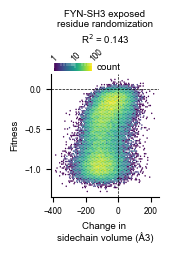

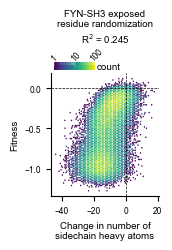

In [12]:
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr
import matplotlib.patches as mpatches
from matplotlib.ticker import MultipleLocator, AutoLocator

proteins = ['P06241']
subcategories = {'Volume':'Volume',
                'Number of sidechain heavy atoms':'#SC atoms'}
protein_names = {'P06241': 'FYN-SH3'}

for protein in proteins:
    bestindices = {'Volume': 'BIGC670101', 'Number of sidechain heavy atoms': 'SCHeavyAtoms'}
    for prop in ['Volume','Number of sidechain heavy atoms']:
        x = percent_change_df[[bestindices[prop]]].to_numpy()
        y = core_variants[['fitness']].to_numpy()
        model = LinearRegression()
        model.fit(x,y)
        y_pred = model.predict(x)
        
        fig, ax = plt.subplots(figsize=(1.4,1.6))
        hbin=ax.hexbin(y= core_variants[['fitness']],x=percent_change_df[[bestindices[prop]]],bins='log',gridsize=75,rasterized=True,linewidths=0)

        plt.axvline(0, ls='--', color='black', lw=0.5)
        plt.axhline(0, ls='--', color='black', lw=0.5)
        
        plt.title(protein_names[protein]+' exposed\nresidue randomization'+'\nR$^2$ = '+str(round(r2_score(y,y_pred),3)),fontsize=7, color='k', loc='center', pad=22)
        
        plt.ylabel('Fitness', fontsize=7)
        plt.xticks(fontsize=6)
        if prop == 'Volume':
            plt.xlabel('Change in \nsidechain volume (Å3)', fontsize=7)
            merge=percent_change_df[['BIGC670101']].merge(core_variants[['fitness']],left_index=True,right_index=True)
        else:
            plt.xlabel('Change in number of\nsidechain heavy atoms',fontsize=7)
        plt.yticks(fontsize=6)
        ax = plt.gca()

        auto_locator = AutoLocator()
        default_ticks = auto_locator.tick_values(*ax.get_xlim())

        if len(default_ticks) > 1:
            tick_interval = default_ticks[1] - default_ticks[0]
            refined_locator = MultipleLocator(tick_interval*2)
            ax.xaxis.set_major_locator(refined_locator)
        ax.spines[['top','right']].set_visible(False)
        ax.set_rasterization_zorder(0)
        fmt = '%1.f'
        cax=fig.add_axes([0.15,0.9,0.3,0.05])
        cb=fig.colorbar(hbin, ax=ax, shrink=0.7,format=fmt,location='top',cax=cax)
        cb.outline.set_visible(False)
        cb.ax.tick_params(axis='both', which='both',direction='in', color='white',width=0.25)
        cb.ax.xaxis.set_tick_params(pad=0)
        cb.set_ticks([1,10,100])
        cb.set_ticklabels([1,10,100], fontsize=6, rotation=45)
        ax1 = cb.ax
        ax1.text(100,0.1,'count',rotation=0, fontsize=7)
        
        plt.show()

## Panel F

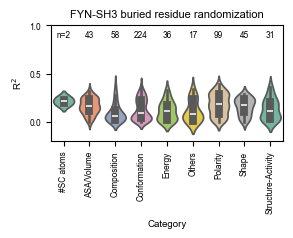

In [13]:
from scipy.stats import pearsonr
import seaborn as sns
plt.rcParams['font.family'] = 'Arial'

proteins = ['P06241']
proteins_dict = {'P06241':'FYN-SH3'}
for protein in proteins:
    
    r_all = []
    pvals = []
    for prop in percent_change_df.columns:
        x = percent_change_df[prop]
        y = core_variants['fitness']
    
        if np.all(x == x.iloc[0]):
            r_all.append(np.nan)
            pvals.append(np.nan)
        else:
            r, p = pearsonr(x, y)
            r_all.append(r)
            pvals.append(p)

    r_all = pd.DataFrame(r_all, index=percent_change_df.columns)
    r_all.columns = ['r']
    r_all['r_square'] = r_all['r']**2
    r_all = r_all.sort_values('r_square', ascending=False).dropna(subset=['r'], axis=0)

    r_all['name'] = aaindex_featureNames.loc[r_all.index, 'name']
    r_all['category'] = AAont.loc[r_all.index, 'category']
    r_all['subcategory'] = AAont.loc[r_all.index, 'subcategory']
    r_all = r_all.sort_values('category',ascending=True)

    plt.subplots(figsize=(3,1.5))
    sns.violinplot(x='category', y='r_square', data=r_all, palette='Set2', hue='category', legend=False)

    category_counts = r_all['category'].value_counts()

    for i, category in enumerate(r_all['category'].unique()):
        n = category_counts[category]
        if i == 0:
            plt.text(i, 0.9, f'n={n}', ha='center', va='center', fontsize=6)
        else:
            plt.text(i, 0.9, f'{n}', ha='center', va='center', fontsize=6)
    
    plt.xticks(rotation=90,fontsize=6)
    plt.yticks(fontsize=6)
    plt.xlabel('Category', fontsize=7)
    plt.ylabel('R$^2$', fontsize=7)
    plt.ylim(-0.2,1)
    plt.title(proteins_dict[protein]+' buried residue randomization',fontsize=8)
    plt.show()